In [108]:
!pip install fuzzy-c-means

In [109]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from itertools import chain
from fcmeans import FCM
import math

In [110]:
#Get vocabulary & counts for hashtag appearances
#hashtag_counts: a dictionary with key: a hashtag, value: count of that hashtag in the file

my_dir = './data'
for item in os.listdir(my_dir):
    filepath = os.path.join(my_dir, item)
    if os.path.isfile(filepath) and 'merged' in filepath:
        print(filepath)
        df = pd.read_csv(os.path.join(my_dir, item))
        df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))
        
        #ignore case of hashtags
        df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])
        
        #Remove tweets that do not contain #capitolriots
        to_drop=[]
        for i,row in df.iterrows():
            if 'capitolriots' not in row['Hashtags_lower']:
                to_drop.append(i)
        df.drop(to_drop, axis=0, inplace=True)
        
        #ignore duplicate hashtags
        df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))
        
        tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

./data/scraped_tweets_merged
126870


In [111]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

4539


In [112]:
#Average number of hashtags in each tweet
print(bow.nnz/bow.shape[0])

3.1387483250571453


In [113]:
#Commented out because was taking way too long to run

# #Fuzzy C-means Clustering

# bow_arr = bow.toarray()

# true_k=3
# fcm = FCM(n_clusters=true_k)
# fcm.fit(bow_arr)
# predictions = fcm.predict(bow_arr)

In [114]:
# #Number of tweets in each cluster
# cluster_counts=[0 for _ in range(true_k)]
# for asn in predictions:
#     cluster_counts[asn]+=1
# print(cluster_counts)

In [115]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

[9739.587002768647, 5423.623155333534, 4358.79616435398, 3491.8102850769938, 2906.4890803495737, 2643.2512315979766, 2418.7468062210437, 2302.1216524561755]


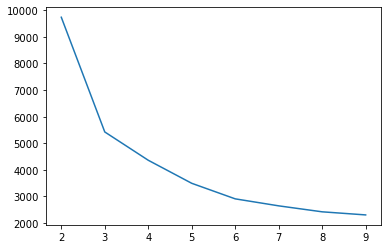

In [116]:
#Choosing optimal k

distances=[]
for i in range(2,10):
    k_svd=i
    fcm_svd = FCM(n_clusters=k_svd)
    fcm_svd.fit(bow_svd)
    predictions_svd = fcm_svd.predict(bow_svd)
    centers = fcm_svd.centers
    
    #dist = math.hypot(x2 - x1, y2 - y1)
    temp=[0 for _ in range(i)]
    for j in range(len(bow_svd)):
        c=predictions_svd[j]
        cnt=centers[c]
        pt=bow_svd[j]
        temp[c]+=math.hypot(cnt[0]-pt[0], cnt[1]-pt[1])
    distances.append(sum(temp))

print(distances)
ax = plt.axes()
ax.plot([i for i in range(2,10)], distances)

Text(0.5, 1.0, 'All data')

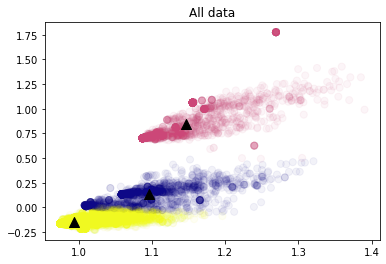

In [135]:
#Run fuzzy clustering on the lower-dimension bow

k_svd=3
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('All data')

In [118]:
my_dir = './data'
df = pd.read_csv('./data/scraped_tweets_tf1')
df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))

#ignore case of hashtags
df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])

#Remove tweets that do not contain #capitolriots
to_drop=[]
for i,row in df.iterrows():
    if 'capitolriots' not in row['Hashtags_lower']:
        to_drop.append(i)
df.drop(to_drop, axis=0, inplace=True)

#ignore duplicate hashtags
df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))

tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

62025


In [119]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

2378


In [120]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

[5595.880367050287, 4140.637884627403, 2601.8212686297725, 2221.913665371954, 1802.1756728607554, 1505.9326804203215, 1585.1596175242814, 1337.6252564057627]


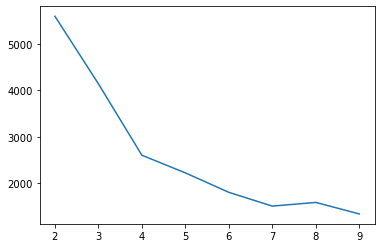

In [121]:
#Choosing optimal k
#Calculate sum of distances from each point to its cluster center

distances=[]
for i in range(2,10):
    k_svd=i
    fcm_svd = FCM(n_clusters=k_svd)
    fcm_svd.fit(bow_svd)
    predictions_svd = fcm_svd.predict(bow_svd)
    centers = fcm_svd.centers
    
    #dist = math.hypot(x2 - x1, y2 - y1)
    temp=[0 for _ in range(i)]
    for j in range(len(bow_svd)):
        c=predictions_svd[j]
        cnt=centers[c]
        pt=bow_svd[j]
        temp[c]+=math.hypot(cnt[0]-pt[0], cnt[1]-pt[1])
    distances.append(sum(temp))

print(distances)
ax = plt.axes()
ax.plot([i for i in range(2,10)], distances)

Text(0.5, 1.0, 'Timeframe 1')

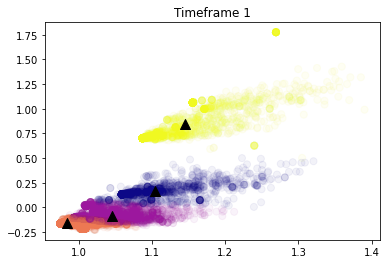

In [136]:
#Run fuzzy clustering on the lower-dimension bow

k_svd=4
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('Timeframe 1')

In [123]:
my_dir = './data'
df = pd.read_csv('./data/scraped_tweets_tf2')
df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))

#ignore case of hashtags
df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])

#Remove tweets that do not contain #capitolriots
to_drop=[]
for i,row in df.iterrows():
    if 'capitolriots' not in row['Hashtags_lower']:
        to_drop.append(i)
df.drop(to_drop, axis=0, inplace=True)

#ignore duplicate hashtags
df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))

tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

46600


In [124]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

2185


In [125]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

[2507.3742745235845, 1506.5389959953889, 1197.41043246017, 994.116094899511, 909.4083837569265, 784.8785428304375, 715.1955906726267, 702.6814778275055]


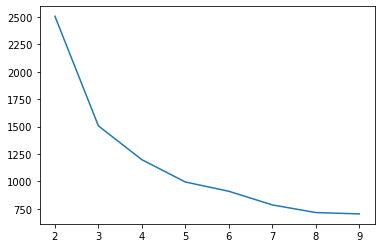

In [126]:
#Choosing optimal k

distances=[]
for i in range(2,10):
    k_svd=i
    fcm_svd = FCM(n_clusters=k_svd)
    fcm_svd.fit(bow_svd)
    predictions_svd = fcm_svd.predict(bow_svd)
    centers = fcm_svd.centers
    
    #dist = math.hypot(x2 - x1, y2 - y1)
    temp=[0 for _ in range(i)]
    for j in range(len(bow_svd)):
        c=predictions_svd[j]
        cnt=centers[c]
        pt=bow_svd[j]
        temp[c]+=math.hypot(cnt[0]-pt[0], cnt[1]-pt[1])
    distances.append(sum(temp))

print(distances)
ax = plt.axes()
ax.plot([i for i in range(2,10)], distances)

Text(0.5, 1.0, 'Timeframe 2')

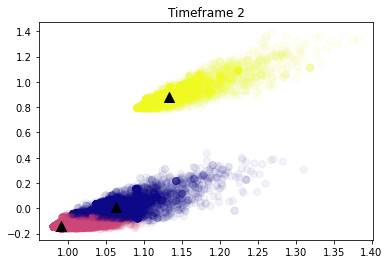

In [127]:
#Run fuzzy clustering on the lower-dimension bow

k_svd=3
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('Timeframe 2')

In [128]:
my_dir = './data'
df = pd.read_csv('./data/scraped_tweets_tf3')
df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))

#ignore case of hashtags
df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])

#Remove tweets that do not contain #capitolriots
to_drop=[]
for i,row in df.iterrows():
    if 'capitolriots' not in row['Hashtags_lower']:
        to_drop.append(i)
df.drop(to_drop, axis=0, inplace=True)

#ignore duplicate hashtags
df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))

tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

18245


In [129]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

1106


In [130]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

[1456.3837581500957, 951.5731953107148, 766.1487477467605, 586.4340899055586, 511.13723555550155, 470.41868394445396, 443.1579165146273, 410.91189020732725]


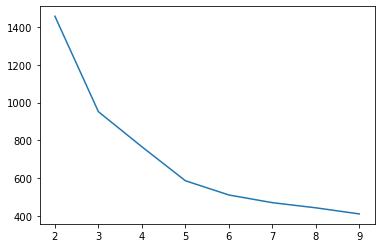

In [131]:
#Choosing optimal k

distances=[]
for i in range(2,10):
    k_svd=i
    fcm_svd = FCM(n_clusters=k_svd)
    fcm_svd.fit(bow_svd)
    predictions_svd = fcm_svd.predict(bow_svd)
    centers = fcm_svd.centers
    
    #dist = math.hypot(x2 - x1, y2 - y1)
    temp=[0 for _ in range(i)]
    for j in range(len(bow_svd)):
        c=predictions_svd[j]
        cnt=centers[c]
        pt=bow_svd[j]
        temp[c]+=math.hypot(cnt[0]-pt[0], cnt[1]-pt[1])
    distances.append(sum(temp))

print(distances)
ax = plt.axes()
ax.plot([i for i in range(2,10)], distances)

Text(0.5, 1.0, 'Timeframe 3')

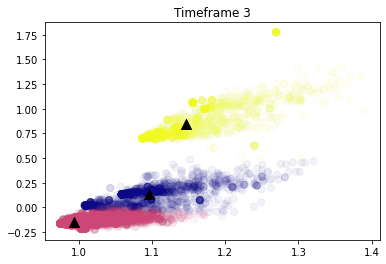

In [132]:
#Run fuzzy clustering on the lower-dimension bow

k_svd=3
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('Timeframe 3')